In [2]:
import itertools as itt
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
import pickle
import scipy.optimize as spo
import scipy.special as spsp
import scipy.stats as sps
import seaborn as sns

from matplotlib.ticker import FixedLocator

mpl.rcParams['axes.titlesize'] = 'xx-large'
mpl.rcParams['axes.labelsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.fontsize'] = 'large'

path_proj = os.getcwd()+ '/'
path_sc = path_proj+'csv/Single_cell/'
path_sort = path_proj+'csv/Sort/'
print(path_proj)

#LOAD THE PROCESSED DATA
df = pd.read_csv(path_sc+'Pooled_data.csv', sep=';', decimal=',')

#GLOBAL VARIABLES FOR ITERATION
or_cells = ['SLAM-HSC', 'ST-HSC', 'MPP']
conds = ['P', 'P+ILs']
times = ['24h', '48h']

#SET A RANDOM SEED TO REPLICATE THE P-VALUES
#FROM STATISTICAL TESTS BASED ON RANDOM PERMUTATIONS
np.random.seed(123)

/Users/giulio/Desktop/perso/curie/cross analysis/Generational_multiplex_analysis_cloned/


In [3]:
#MAP THE VECTORS OF counts OF classes TO A DIFFERENT SUPPORT (USUALLY CONTAINING classes)
def spread_to_support(classes, counts, support):
    counts_sum = counts.sum()
    if counts_sum == 0:
        return np.zeros(len(support))
    else:
        return np.hstack([counts[classes==cl] if any(classes==cl) else np.zeros(1) for cl in support])

#CALCULATE THE G-TEST STATISTIC ON data WITH labels,
#ON THE CONTINGENCY TABLE OF support (DATA SUPPORT) X all_perm_labels (LABELS SUPPORT)
def chi_squared_stat(data, labels, support, all_perm_labels, bool_stack=True):
    if bool_stack:
        table = np.array([
            spread_to_support(*np.unique(np.hstack(data[labels==k]), return_counts=True),
                              support=support)
            for k in all_perm_labels
        ])
    else:
        table = np.array([
            spread_to_support(*np.unique(data[labels==k], return_counts=True),
                              support=support)
            for k in all_perm_labels
        ])
    return sps.chi2_contingency(table, correction=False, lambda_='log-likelihood')[0]

####PERMUTATION TESTING
#INPUT
#    stat_func: the statistic to be calculated on data and permuted data
#    args: fixed input variables for stat_func
#    data: array of data to be permuted 
#    perm_label: array of labels, with same lenght as data, used to permute data
#    n_iter: number of permuted data to be drawn
#    boold_p_dist: if True, also return the stat_func calculated on the permuted data.
#        Useful to plot the statistic' distribution. 
#OUTPUT: left, right and two-sided pvalues;
#        if boold_p_dist=True, also return the permuted versions of the statistics

def permutation_testing(stat_func, args, data, perm_label, n_iter=250000, boold_p_dist=False):
    stat = stat_func(data, perm_label, *args)
    perm_stat = np.array([
        stat_func(data, perm_label[np.random.permutation(len(perm_label))], *args)
        for k in np.arange(n_iter)])
    
    left_pval = ((perm_stat <= stat).sum()+1.)/(n_iter+1.)
    right_pval = ((perm_stat >= stat).sum()+1.)/(n_iter+1.)
    two_sided_pval = min(2 * min(left_pval, right_pval), 1)
    if boold_p_dist:
        return {'left':left_pval, 'right':right_pval, 'two-sided':two_sided_pval}, stat, perm_stat
    else:
        return {'left':left_pval, 'right':right_pval, 'two-sided':two_sided_pval}

In [5]:
#FIG 2B
pvals_dct = {}
for oc in or_cells:
    print(oc)
    df_temp = df[(df.Original_cell==oc)]

    data = np.array([df_temp[(df_temp.Family==fam)].Class.values
                     for fam in np.unique(df_temp.Family)])
    perm_label = np.array([df_temp[(df_temp.Family==fam)].Culture_condition.iloc[0]
                           for fam in np.unique(df_temp.Family)])
    
    table_support = np.unique(np.hstack(data))
    all_perm_labels = np.unique(perm_label)
    bool_stack = True
    args = (table_support, all_perm_labels, bool_stack,)
    
    pvals_dct[oc] = permutation_testing(chi_squared_stat, args, data, perm_label)
print(pvals_dct)
with open('./pickled_data/Fig2B_pvals', 'wb') as fp:
    pickle.dump(pvals_dct, fp)

SLAM-HSC
ST-HSC
MPP
{'SLAM-HSC': {'left': 0.842688629245483, 'right': 0.15731537073851704, 'two-sided': 0.31463074147703407}, 'ST-HSC': {'left': 0.999996000016, 'right': 7.999968000127999e-06, 'two-sided': 1.5999936000255998e-05}, 'MPP': {'left': 1.0, 'right': 3.9999840000639995e-06, 'two-sided': 7.999968000127999e-06}}


In [6]:
###FIG 2C
## Measure of progression of familial progression
def depth_mdd(g):
    generations, counts = np.unique(g, return_counts=True)
    cn = np.power(2., -generations)
    num = sum( generations * cn * counts )
    den = sum( cn * counts )
    if den == 0.:
        return 0.
    else:
        return num/den

def depth_max(g):
    return max(g)

pvals_dct = {}
for oc in or_cells:
    print(oc)
    df_temp = df[(df.Original_cell==oc)]

    data = np.array([depth_max(df_temp[(df_temp.Family==fam)].Generation)
                     for fam in np.unique(df_temp.Family)])
    perm_label = np.array([df_temp[(df_temp.Family==fam)].Culture_condition.iloc[0]
                           for fam in np.unique(df_temp.Family)])
    
    table_support = np.unique(data)
    all_perm_labels = np.unique(perm_label)
    bool_stack = False
    args = (table_support, all_perm_labels, bool_stack,)
    
    pvals_dct[oc] = permutation_testing(chi_squared_stat, args, data, perm_label)
print(pvals_dct)
        
with open('./pickled_data/Fig2C_pvals', 'wb') as fp:
    pickle.dump(pvals_dct, fp)

SLAM-HSC
ST-HSC
MPP
{'SLAM-HSC': {'left': 0.9653961384154464, 'right': 0.03461186155255379, 'two-sided': 0.06922372310510758}, 'ST-HSC': {'left': 0.9923960304158783, 'right': 0.007607969568121728, 'two-sided': 0.015215939136243455}, 'MPP': {'left': 0.9810240759036963, 'right': 0.018983924064303742, 'two-sided': 0.037967848128607484}}


In [7]:
with open('./pickled_data/Fig2C_pvals', 'rb') as fp:
    pvals_dct = pickle.load(fp)
pvals_dct

{'MPP': {'left': 0.9810240759036963,
  'right': 0.018983924064303742,
  'two-sided': 0.037967848128607484},
 'SLAM-HSC': {'left': 0.9653961384154464,
  'right': 0.03461186155255379,
  'two-sided': 0.06922372310510758},
 'ST-HSC': {'left': 0.9923960304158783,
  'right': 0.007607969568121728,
  'two-sided': 0.015215939136243455}}

In [8]:
###FIG 2D
pvals_dct = {}
for oc in or_cells:
    print(oc)
    df_temp = df[(df.Original_cell==oc)&(df.Generation==0)]

    data = np.array([df_temp[(df_temp.Family==fam)].Class.iloc[0]
                     for fam in np.unique(df_temp.Family)])
    perm_label = np.array([df_temp[(df_temp.Family==fam)].Culture_condition.iloc[0]
                           for fam in np.unique(df_temp.Family)])
    
    table_support = np.unique(data)
    all_perm_labels = np.unique(perm_label)
    bool_stack = False
    args = (table_support, all_perm_labels, bool_stack,)
    
    pvals_dct[oc] = permutation_testing(chi_squared_stat, args, data, perm_label)
print(pvals_dct)
        
with open('./pickled_data/Fig2D_pvals', 'wb') as fp:
    pickle.dump(pvals_dct, fp)

SLAM-HSC
ST-HSC
MPP
{'SLAM-HSC': {'left': 0.646501413994344, 'right': 0.35420258318966724, 'two-sided': 0.7084051663793345}, 'ST-HSC': {'left': 0.8933844264622941, 'right': 0.10661957352170591, 'two-sided': 0.21323914704341182}, 'MPP': {'left': 0.9981200075199699, 'right': 0.0018839924640301439, 'two-sided': 0.0037679849280602877}}


In [9]:
#FIG 2E
sym_labs = ['SYM UNDIF', 'SYM DIF', 'ASYM UNDIF', 'ASYM DIF']

def first_div_class(df):#sis_type, prog_type):
    daugher1, daugher2 = df.Class.values
    progenitor = df.Original_cell.values[0]
    if daugher1 == daugher2:
        if daugher1 == progenitor:
            return sym_labs[0]
        else:
            return sym_labs[1]
    else:
        if (daugher1 == progenitor) or (daugher2 == progenitor):
            return sym_labs[2]
        else:
            return sym_labs[3]
    
pvals_dct = {}
for oc in or_cells:
    print(oc)
    df_temp = df[(df.Original_cell==oc)&(df.Generation==1)]

    data = np.array([first_div_class(df_temp[df_temp.Family==fam])
                     for fam in np.unique(df_temp.Family) if len(df_temp[df_temp.Family==fam])==2])
    perm_label = np.array([df_temp[(df_temp.Family==fam)].Culture_condition.iloc[0]
                           for fam in np.unique(df_temp.Family) if len(df_temp[df_temp.Family==fam])==2])
    
    table_support = np.unique(data)
    all_perm_labels = np.unique(perm_label)
    bool_stack = False
    args = (table_support, all_perm_labels, bool_stack,)
    
    pvals_dct[oc] = permutation_testing(chi_squared_stat, args, data, perm_label)
print(pvals_dct)
        
with open('./pickled_data/Fig2E_pvals', 'wb') as fp:
    pickle.dump(pvals_dct, fp)

SLAM-HSC
ST-HSC
MPP
{'SLAM-HSC': {'left': 0.23293906824372704, 'right': 0.7787488850044599, 'two-sided': 0.4658781364874541}, 'ST-HSC': {'left': 0.6389534441862232, 'right': 0.38085447658209365, 'two-sided': 0.7617089531641873}, 'MPP': {'left': 0.8721325114699541, 'right': 0.1326434694261223, 'two-sided': 0.2652869388522446}}


In [26]:
#SUPPLEMENTARY FIG 2B
pvals_dct = {}
for oc in or_cells:
    print(oc)
    df_temp = df[(df.Original_cell==oc)&(df.Generation==1)]

    data = np.array([df_temp[(df_temp.Family==fam)].Class.values
                     for fam in np.unique(df_temp.Family)])
    perm_label = np.array([df_temp[(df_temp.Family==fam)].Culture_condition.iloc[0]
                           for fam in np.unique(df_temp.Family)])
    
    table_support = np.unique(np.hstack(data))
    all_perm_labels = np.unique(perm_label)
    bool_stack = True
    args = (table_support, all_perm_labels, bool_stack,)
    
    pvals_dct[oc] = permutation_testing(chi_squared_stat, args, data, perm_label)
print(pvals_dct)
with open('./pickled_data/SuppFig2B_pvals', 'wb') as fp:
    pickle.dump(pvals_dct, fp)

SLAM-HSC
ST-HSC
MPP
{'SLAM-HSC': {'left': 0.885312458750165, 'right': 0.11469154123383507, 'two-sided': 0.22938308246767014}, 'ST-HSC': {'left': 0.9996360014559942, 'right': 0.00036799852800588795, 'two-sided': 0.0007359970560117759}, 'MPP': {'left': 0.9999880000479998, 'right': 1.5999936000255998e-05, 'two-sided': 3.1999872000511996e-05}}


In [27]:
#SANITY CHECK: TEST FOR WELL AND EXPERIMENT EFFECT TO FAMILIAL CELL CLASS DISTIRBUTION
#(IN FIXED CONDITION, TIME AND PROGENITOR CLASS)
#FAMILIES ARE PERMUTED ACROSS WELLS AND EXPERIMENTS AFTER THE WELL_EXPERIMENT LABEL
#THE STATISTIC USED IS THE G-TEST STATISTIC ON THE CONTINGENCY TABLE OF CELL COUNTS
#SORTED BY CELL CLASS VS WELL_EXPERIMENT LABEL

pvals_dct = {}
for oc in or_cells:
    pvals_dct[oc] = {}
    for cnd in conds:
        pvals_dct[oc][cnd] = {}
        for t in times:
            print(oc, cnd, t)
            df_temp = df[(df.Original_cell==oc)&(df.Culture_condition==cnd)&(df.Culture_time==t)]

            data = np.array([df_temp[(df_temp.Family==fam)].Class.values
                             for fam in np.unique(df_temp.Family)])
            perm_label = np.array([df_temp[(df_temp.Family==fam)].Well_experiment.iloc[0]
                                   for fam in np.unique(df_temp.Family)])

            table_support = np.unique(np.hstack(data))
            all_perm_labels = np.unique(perm_label)
            bool_stack = True
            args = (table_support, all_perm_labels, bool_stack,)

            pvals_dct[oc][cnd][t] = permutation_testing(chi_squared_stat, args, data, perm_label)
with open('./pickled_data/WellExperiment_test_pvals', 'wb') as fp:
    pickle.dump(pvals_dct, fp)

SLAM-HSC P 24h
SLAM-HSC P 48h
SLAM-HSC P+ILs 24h
SLAM-HSC P+ILs 48h
ST-HSC P 24h
ST-HSC P 48h
ST-HSC P+ILs 24h
ST-HSC P+ILs 48h
MPP P 24h
MPP P 48h
MPP P+ILs 24h
MPP P+ILs 48h


In [28]:
with open('./pickled_data/WellExperiment_test_pvals', 'rb') as fp:
    pvals_dct = pickle.load(fp)
for oc in or_cells:
    for cnd in conds:
        for t in times:
            print(oc, cnd, t, '\t', pvals_dct[oc][cnd][t]['right'])

SLAM-HSC P 24h 	 0.008683965264138943
SLAM-HSC P 48h 	 0.5123499506001976
SLAM-HSC P+ILs 24h 	 0.2304630781476874
SLAM-HSC P+ILs 48h 	 0.6260374958500166
ST-HSC P 24h 	 0.2593549625801497
ST-HSC P 48h 	 0.0967436130255479
ST-HSC P+ILs 24h 	 0.6066975732097072
ST-HSC P+ILs 48h 	 0.7582449670201319
MPP P 24h 	 0.24542301830792676
MPP P 48h 	 0.6022295910816357
MPP P+ILs 24h 	 0.37274650901396394
MPP P+ILs 48h 	 0.3910064359742561


## Extended statistical testing

## For fixed original cell and for fixed time, test whether different culture conditions impact the distribution of the number of distinct cell types within progeny

SLAM-HSC 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3330723068.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


SLAM-HSC 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3330723068.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


ST-HSC 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3330723068.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


ST-HSC 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3330723068.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


MPP 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3330723068.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


MPP 48h
{'SLAM-HSC': {'24h': {'left': 0.41441034235863056, 'right': 0.7847688609245563, 'two-sided': 0.8288206847172611}, '48h': {'left': 0.13575945696217215, 'right': 0.9313882744469022, 'two-sided': 0.2715189139243443}}, 'ST-HSC': {'24h': {'left': 0.9994160023359907, 'right': 0.0014879940480238079, 'two-sided': 0.0029759880960476158}, '48h': {'left': 0.9879480482078071, 'right': 0.013095947616209535, 'two-sided': 0.02619189523241907}}, 'MPP': {'24h': {'left': 0.48747805008779965, 'right': 0.7544889820440718, 'two-sided': 0.9749561001755993}, '48h': {'left': 0.8579165683337266, 'right': 0.22995908016367936, 'two-sided': 0.4599181603273587}}}


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3330723068.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


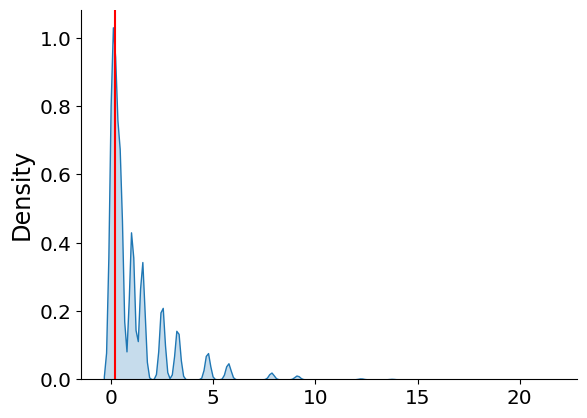

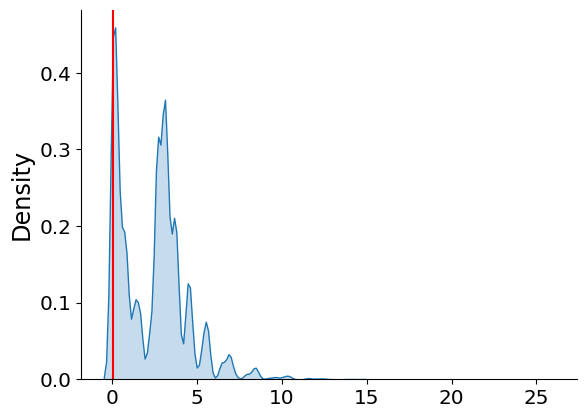

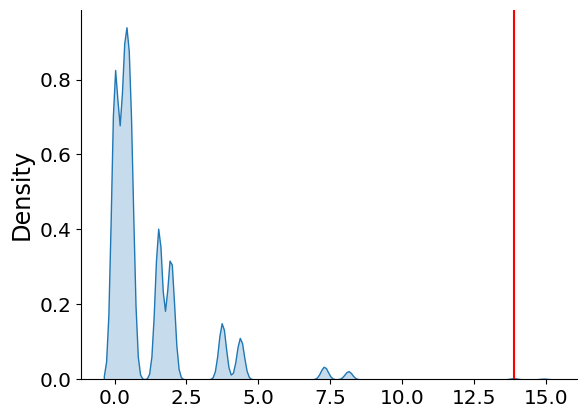

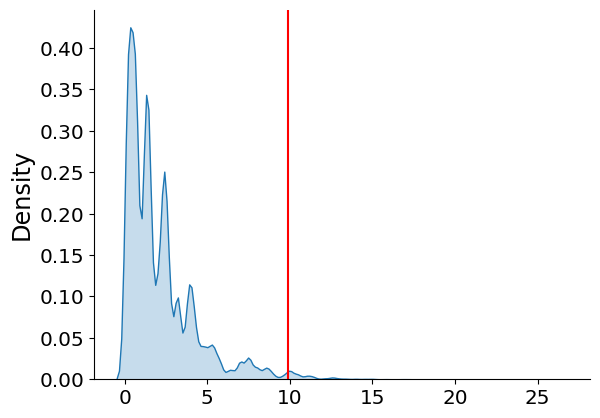

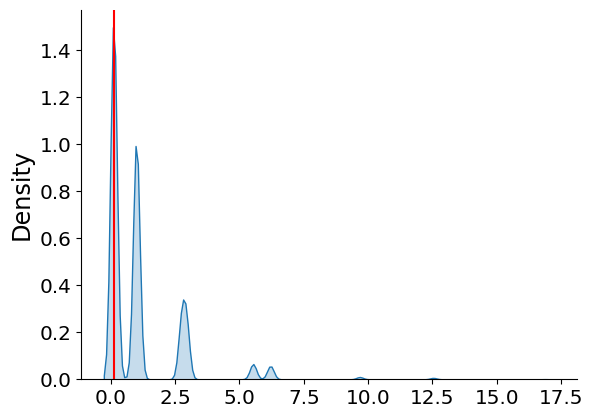

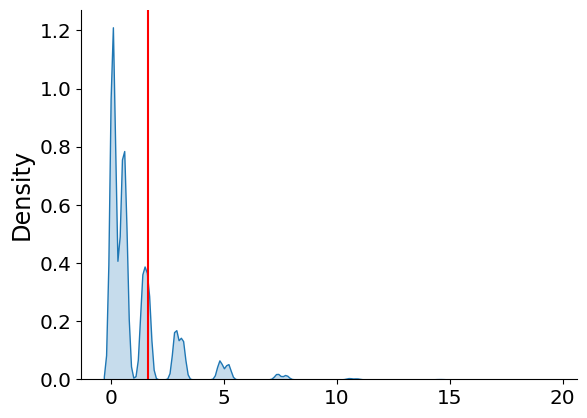

In [4]:
pvals_dct = {oc:{} for oc in or_cells}
for oc in or_cells:
    for tt in times:
        df_temp = df[(df.Culture_time==tt)&(df.Original_cell==oc)]

        data = np.array([
            len(np.unique(df_temp[(df_temp.Family==fam)].Class.values))
            for fam in np.unique(df_temp.Family)])
        
        perm_label = np.array([
            df_temp[(df_temp.Family==fam)].Culture_condition.iloc[0]
            for fam in np.unique(df_temp.Family)])
        
        table_support = np.unique(np.hstack(data))
        all_perm_labels = np.unique(perm_label)
        bool_stack = False
        args = (table_support, all_perm_labels, bool_stack,)
        
        pvals_dct[oc][tt], stat, perm_stat = permutation_testing(chi_squared_stat, args, data, perm_label, boold_p_dist=True)
        print(oc, tt)
    
        fig,ax = plt.subplots()
        sns.kdeplot(perm_stat, fill=True, ax=ax)
        ax.axvline(x=stat, c='r')
        sns.despine(fig=fig)
        fig.show()
    
    
print(pvals_dct)
with open('./pickled_data/lenunique_cvc_pvals.pkl', 'wb') as fp:
    pickle.dump(pvals_dct, fp)

## For fixed original cell and for fixed time, test whether different culture conditions impact the distribution of progeny's cell types

SLAM-HSC 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/2352752731.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


SLAM-HSC 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/2352752731.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


ST-HSC 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/2352752731.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


ST-HSC 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/2352752731.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


MPP 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/2352752731.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


MPP 48h
{'SLAM-HSC': {'24h': {'left': 0.4944820220719117, 'right': 0.5055259778960884, 'two-sided': 0.9889640441438234}, '48h': {'left': 0.8733685065259739, 'right': 0.12663549345802616, 'two-sided': 0.2532709869160523}}, 'ST-HSC': {'24h': {'left': 0.9526161895352419, 'right': 0.04738781044875821, 'two-sided': 0.09477562089751641}, '48h': {'left': 0.999996000016, 'right': 7.999968000127999e-06, 'two-sided': 1.5999936000255998e-05}}, 'MPP': {'24h': {'left': 0.9995440018239927, 'right': 0.00045999816000736, 'two-sided': 0.00091999632001472}, '48h': {'left': 1.0, 'right': 3.9999840000639995e-06, 'two-sided': 7.999968000127999e-06}}}


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/2352752731.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


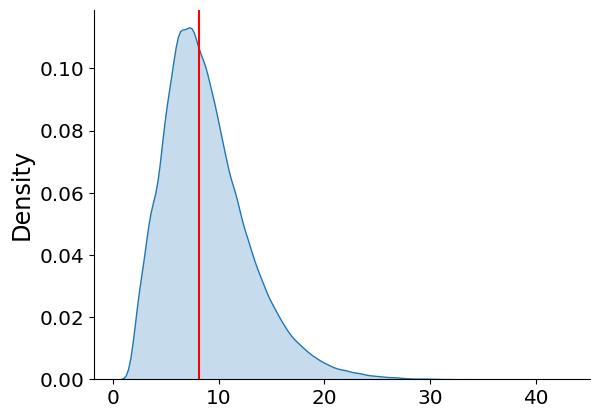

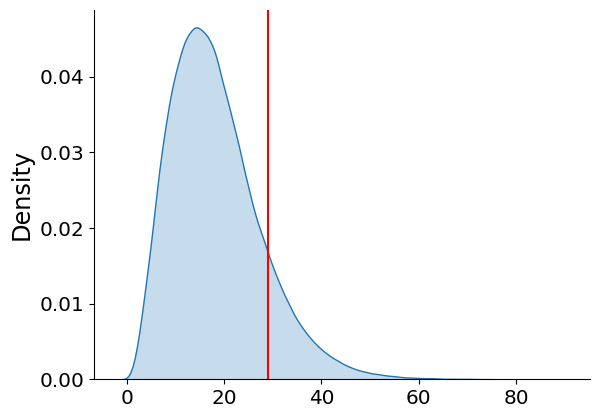

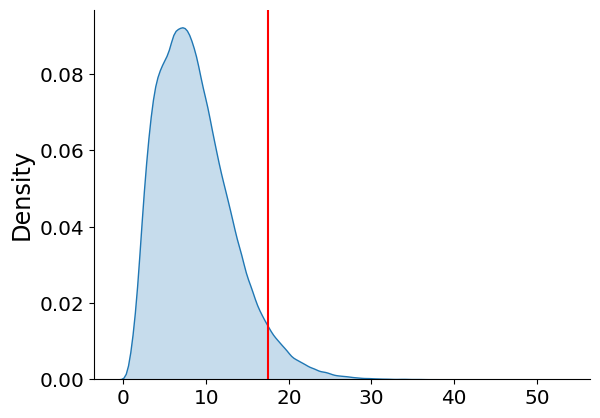

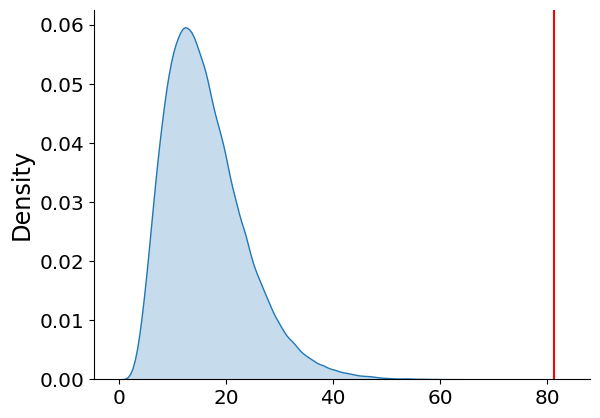

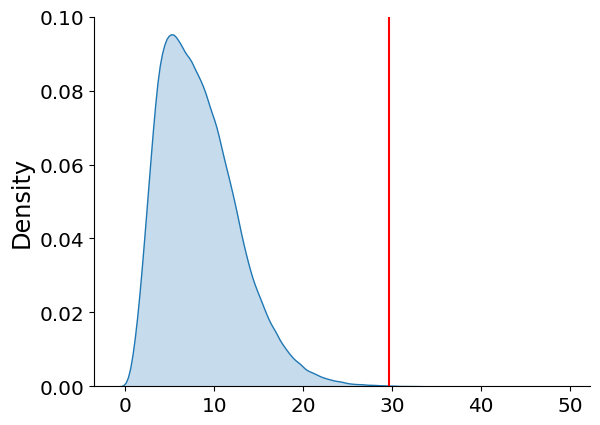

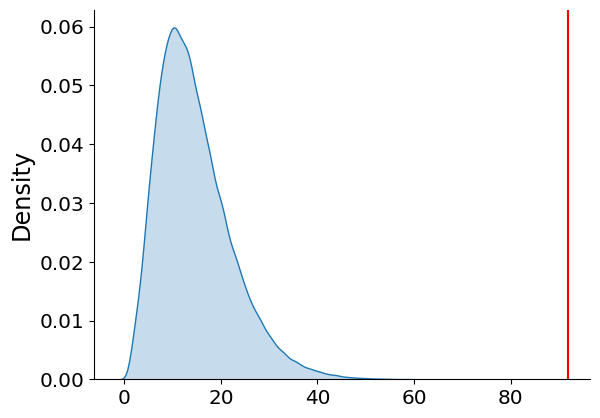

In [5]:
pvals_dct = {oc:{} for oc in or_cells}
for oc in or_cells:
    for tt in times:
        df_temp = df[(df.Culture_time==tt)&(df.Original_cell==oc)]
    
        data = np.array([
            df_temp[(df_temp.Family==fam)].Class.values
            for fam in np.unique(df_temp.Family)], dtype=object)
        
        perm_label = np.array([
            df_temp[(df_temp.Family==fam)].Culture_condition.iloc[0]
            for fam in np.unique(df_temp.Family)])
        
        table_support = np.unique(np.hstack(data))
        all_perm_labels = np.unique(perm_label)
        bool_stack = True
        args = (table_support, all_perm_labels, bool_stack,)
        
        pvals_dct[oc][tt], stat, perm_stat = permutation_testing(chi_squared_stat, args, data, perm_label, boold_p_dist=True)
        print(oc, tt)
    
        fig,ax = plt.subplots()
        sns.kdeplot(perm_stat, fill=True, ax=ax)
        ax.axvline(x=stat, c='r')
        sns.despine(fig=fig)
        fig.show()
    
    
print(pvals_dct)
with open('./pickled_data/classdist_cvc_pvals.pkl', 'wb') as fp:
    pickle.dump(pvals_dct, fp)

## For fixed original cell and for fixed culture condition, test whether different harvesting times impact the distribution of familial range

SLAM-HSC P


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/559067426.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


SLAM-HSC P+ILs


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/559067426.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


ST-HSC P


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/559067426.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


ST-HSC P+ILs


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/559067426.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


MPP P


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/559067426.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


MPP P+ILs
{'SLAM-HSC': {'P': {'left': 0.9992040031839873, 'right': 0.00213999144003424, 'two-sided': 0.00427998288006848}, 'P+ILs': {'left': 0.999996000016, 'right': 2.7999888000448e-05, 'two-sided': 5.5999776000896e-05}}, 'ST-HSC': {'P': {'left': 1.0, 'right': 0.002635989456042176, 'two-sided': 0.005271978912084352}, 'P+ILs': {'left': 0.8353046587813648, 'right': 0.296938812244751, 'two-sided': 0.593877624489502}}, 'MPP': {'P': {'left': 0.9781400874396502, 'right': 0.040759836960652156, 'two-sided': 0.08151967392130431}, 'P+ILs': {'left': 0.4545821816712733, 'right': 0.7005371978512086, 'two-sided': 0.9091643633425466}}}


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/559067426.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


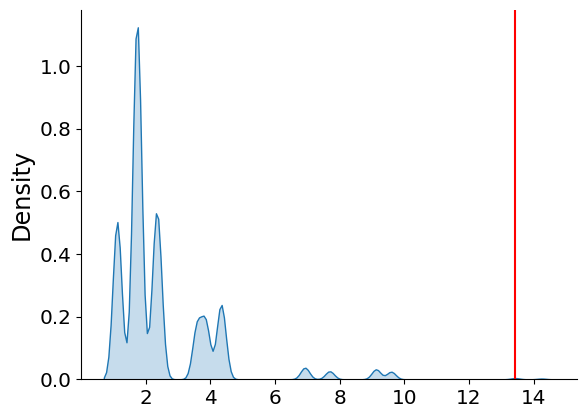

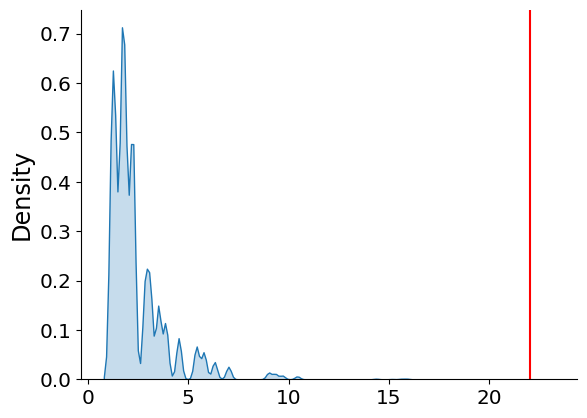

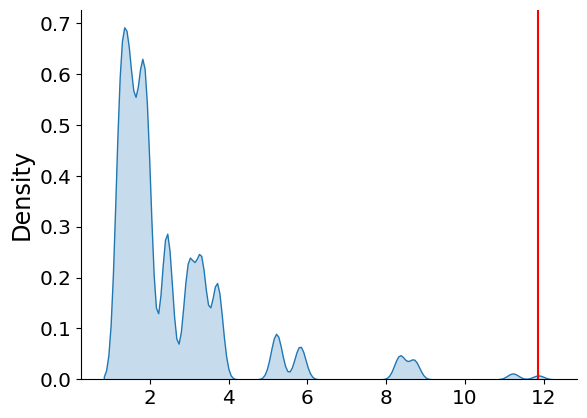

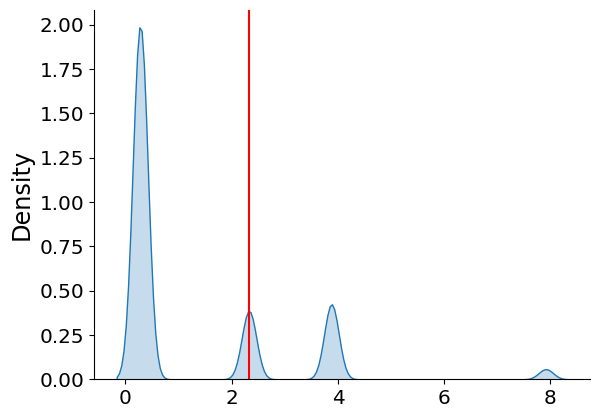

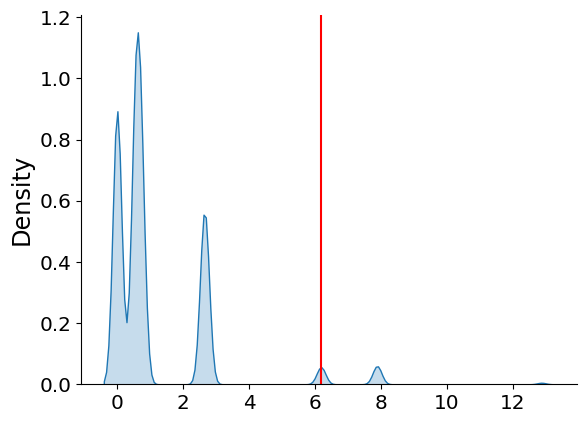

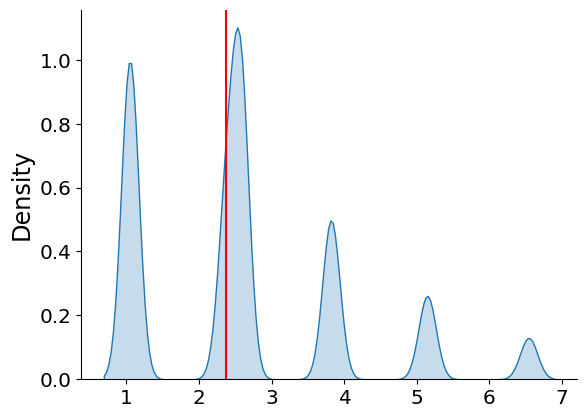

In [6]:
pvals_dct = {oc:{} for oc in or_cells}
for oc in or_cells:
    for cn in conds:
        df_temp = df[(df.Culture_condition==cn)&(df.Original_cell==oc)]
    
        data = np.array([
            df_temp[(df_temp.Family==fam)].Generation.values.max() - df_temp[(df_temp.Family==fam)].Generation.values.min()
            for fam in np.unique(df_temp.Family)], dtype=object)
        
        perm_label = np.array([
            df_temp[(df_temp.Family==fam)].Culture_time.iloc[0]
            for fam in np.unique(df_temp.Family)])
        
        table_support = np.unique(np.hstack(data))
        all_perm_labels = np.unique(perm_label)
        bool_stack = False
        args = (table_support, all_perm_labels, bool_stack,)
        
        pvals_dct[oc][cn], stat, perm_stat = permutation_testing(chi_squared_stat, args, data, perm_label, boold_p_dist=True)
        print(oc, cn)
    
        fig,ax = plt.subplots()
        sns.kdeplot(perm_stat, fill=True, ax=ax)
        ax.axvline(x=stat, c='r')
        sns.despine(fig=fig)
        fig.show()
    
    
print(pvals_dct)
with open('./pickled_data/rangedist_tvt_pvals.pkl', 'wb') as fp:
    pickle.dump(pvals_dct, fp)

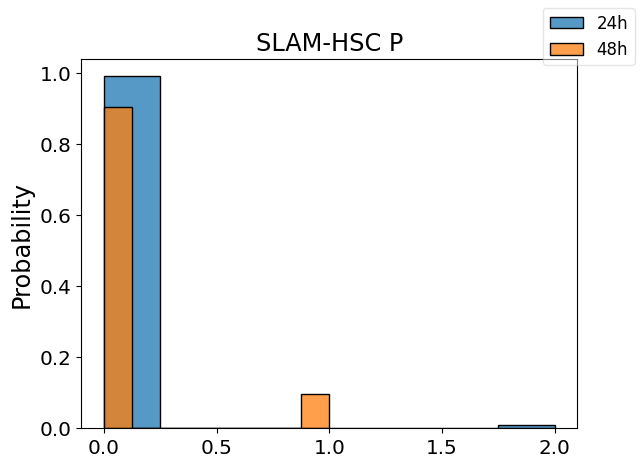

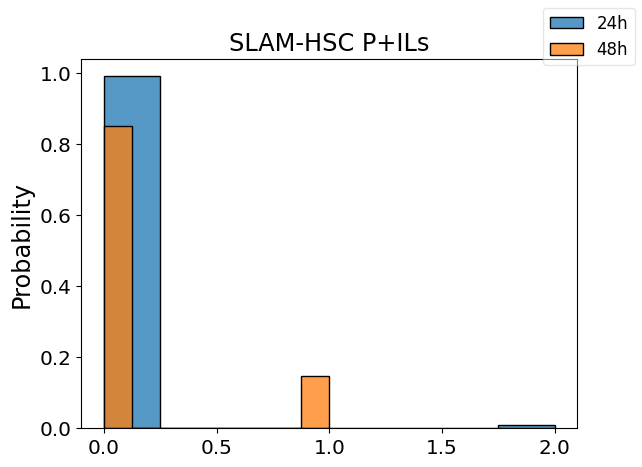

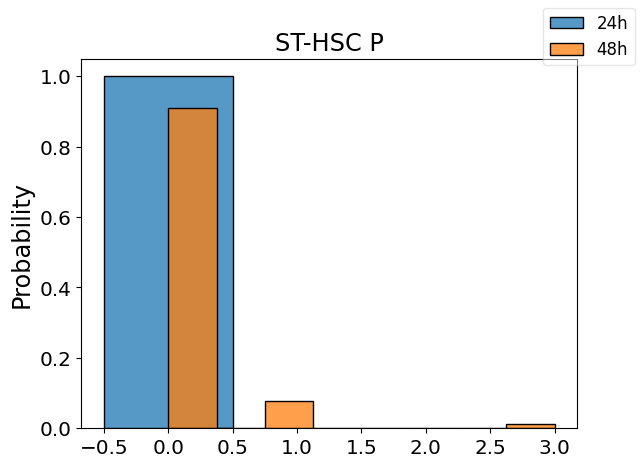

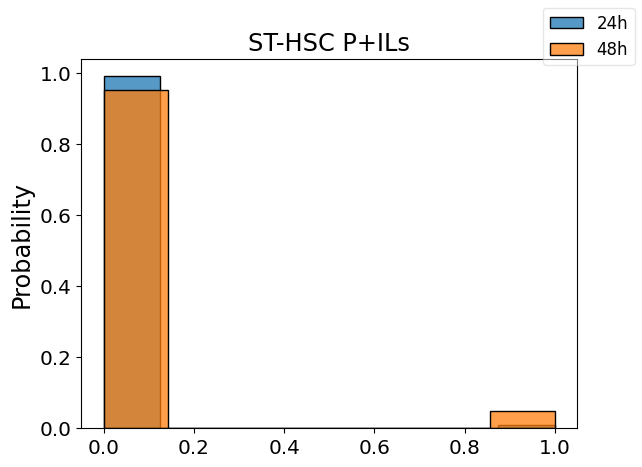

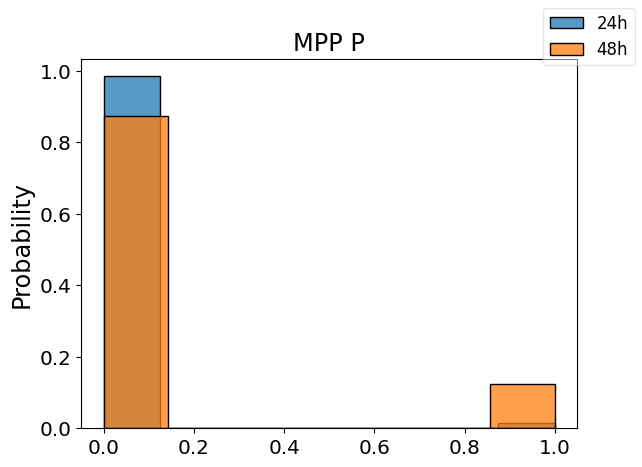

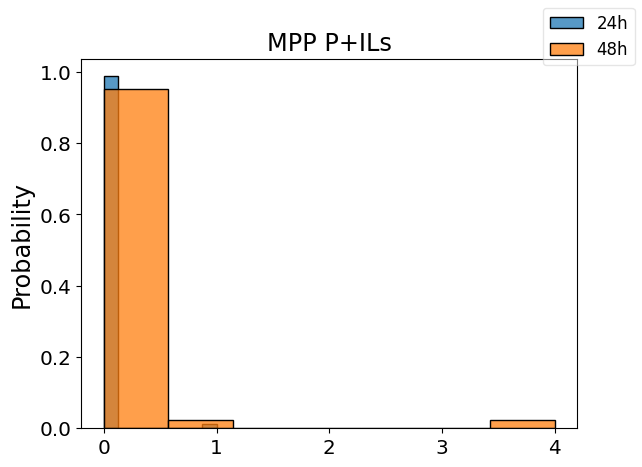

In [7]:
for oc in or_cells:
    for cn in conds:
        df_temp = df[(df.Culture_condition==cn)&(df.Original_cell==oc)]
    
        data = np.array([
            df_temp[(df_temp.Family==fam)].Generation.values.max() - df_temp[(df_temp.Family==fam)].Generation.values.min()
            for fam in np.unique(df_temp.Family)], dtype=object)
        
        perm_label = np.array([
            df_temp[(df_temp.Family==fam)].Culture_time.iloc[0]
            for fam in np.unique(df_temp.Family)])
        
        fig,ax = plt.subplots()
        for k in np.unique(perm_label):
            sns.histplot(data[perm_label==k], ax=ax, stat='probability', label=str(k))
        #sns.histplot(data[perm_label==1], ax=ax, stat='probability', label='range>0')
        ax.set_title(' '.join([oc,cn]))
        fig.legend()

## For each experiment (fixed original cell, fixed time and fixed condition), test whether range positivity (i.e. families with range>0 vs range=0) impacts the distribution of progeny's cell types

(array([0, 1]), array([14,  1]))
SLAM-HSC P 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/411376022.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([41,  7]))
SLAM-HSC P 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/411376022.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([20,  1]))
SLAM-HSC P+ILs 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/411376022.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([53, 12]))
SLAM-HSC P+ILs 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/411376022.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0]), array([11]))
ST-HSC P 24h
(array([0, 1]), array([49,  7]))


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/411376022.py:28: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(perm_stat, fill=True, ax=ax)
/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/411376022.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


ST-HSC P 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/411376022.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([20,  1]))
ST-HSC P+ILs 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/411376022.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([40,  3]))
ST-HSC P+ILs 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/411376022.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([8, 1]))
MPP P 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/411376022.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([18,  6]))
MPP P 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/411376022.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([13,  1]))
MPP P+ILs 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/411376022.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([23,  2]))
MPP P+ILs 48h
{'SLAM-HSC': {'P': {'24h': {'left': 0.5983056067775729, 'right': 0.4680341278634885, 'two-sided': 0.936068255726977}, '48h': {'left': 0.7908968364126544, 'right': 0.2091071635713457, 'two-sided': 0.4182143271426914}}, 'P+ILs': {'24h': {'left': 0.8562365750536998, 'right': 0.19119123523505907, 'two-sided': 0.38238247047011814}, '48h': {'left': 0.8161487354050584, 'right': 0.1838552645789417, 'two-sided': 0.3677105291578834}}}, 'ST-HSC': {'P': {'24h': {'left': 1.0, 'right': 1.0, 'two-sided': 1}, '48h': {'left': 0.8096607613569545, 'right': 0.19035523857904568, 'two-sided': 0.38071047715809136}}, 'P+ILs': {'24h': {'left': 0.23806704773180906, 'right': 0.9525361898552406, 'two-sided': 0.4761340954636181}, '48h': {'left': 0.3487626049495802, 'right': 0.651309394762421, 'two-sided': 0.6975252098991604}}}, 'MPP': {'P': {'24h': {'left': 0.7775888896444414, 'right': 0.44462222151111397, 'two-sided': 0.8892444430222279}, '48h': {'left': 0.9009123963

/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/411376022.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


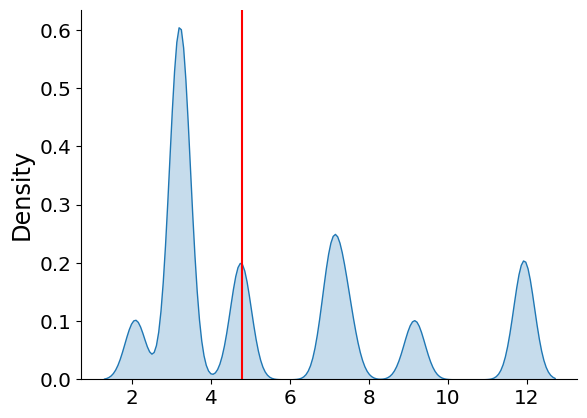

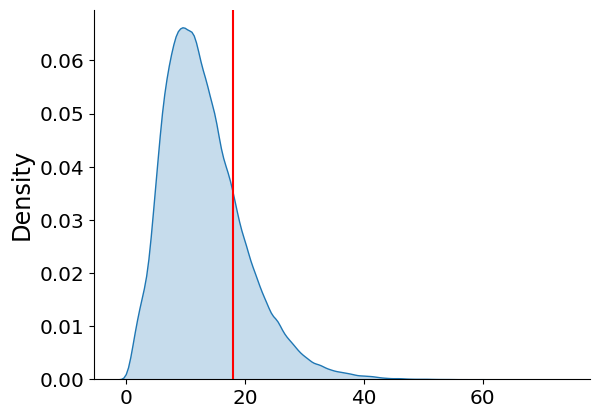

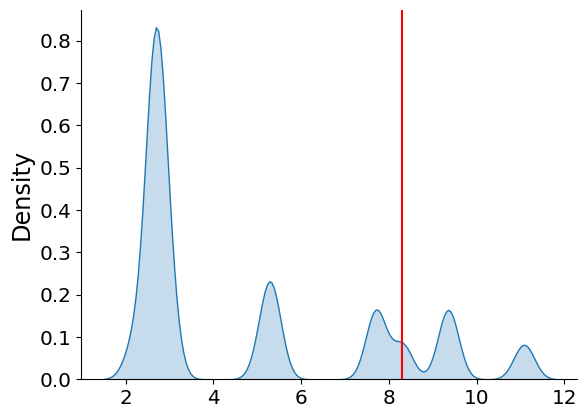

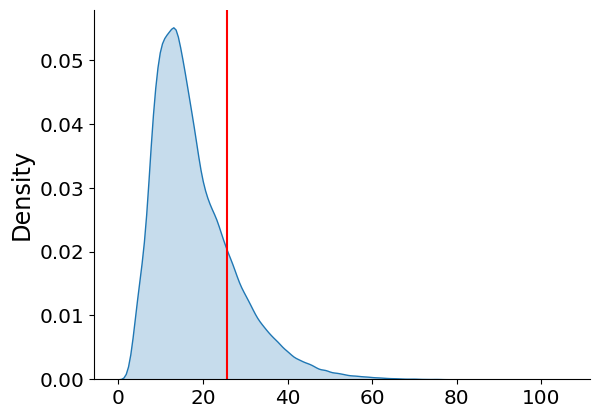

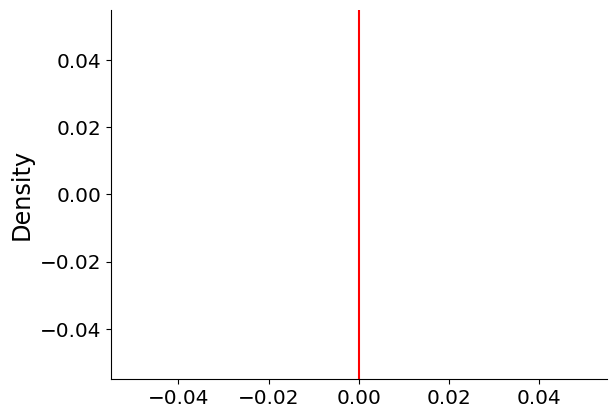

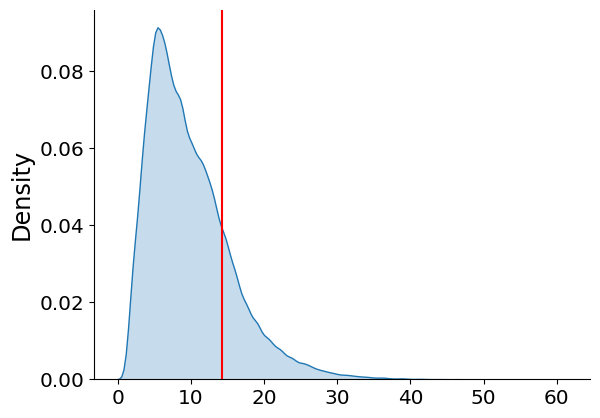

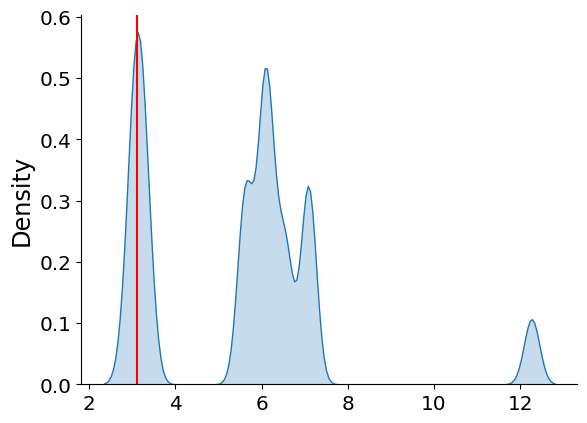

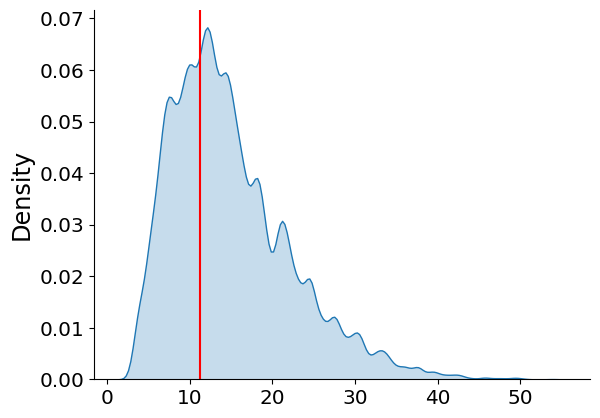

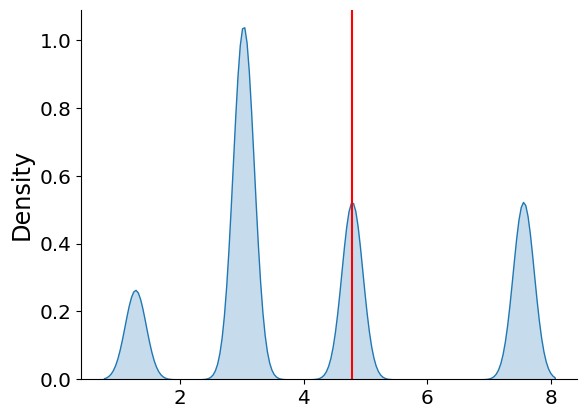

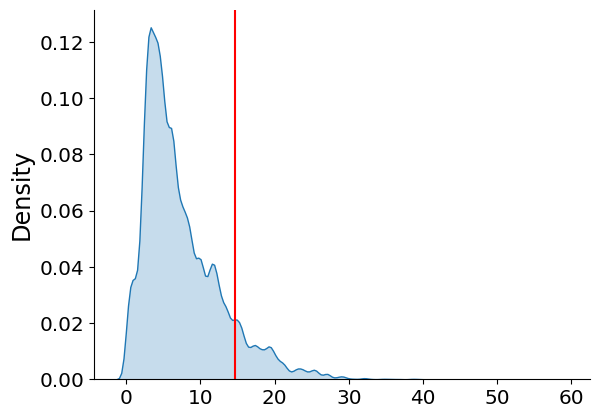

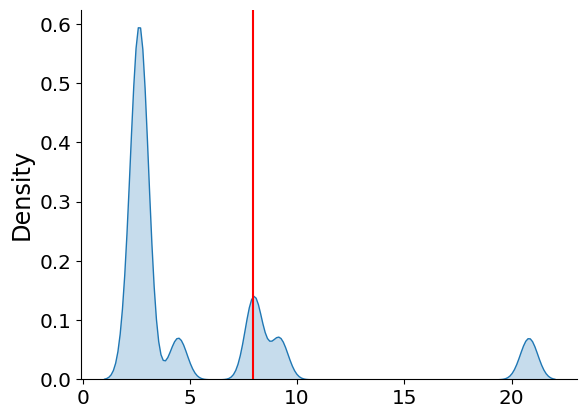

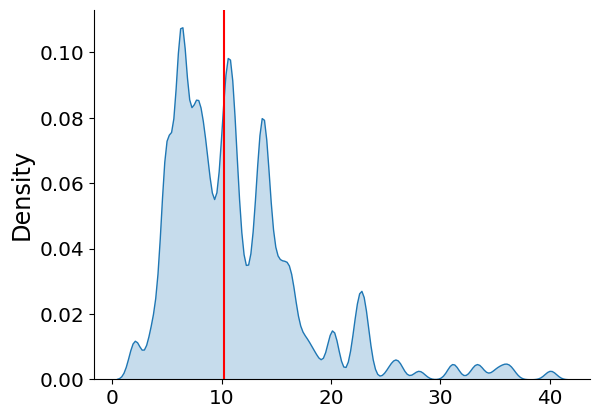

In [8]:
pvals_dct = {oc:{cn:{} for cn in conds} for oc in or_cells}
for oc in or_cells:
    for cn in conds:
        for tt in times:
            df_temp = df[(df.Culture_time==tt)&(df.Culture_condition==cn)&(df.Original_cell==oc)]
            nonatomic_families = [fam for fam in np.unique(df_temp.Family) if (df_temp.Family==fam).sum()>1]
            df_temp = df_temp[df_temp.Family.isin(nonatomic_families)]
            
            data = np.array([
                df_temp[(df_temp.Family==fam)].Class.values
                for fam in np.unique(df_temp.Family)], dtype=object)
        
            perm_label = np.array([
                df_temp[(df_temp.Family==fam)].Generation.values.max() - df_temp[(df_temp.Family==fam)].Generation.values.min()
                for fam in np.unique(df_temp.Family)])
            perm_label = (perm_label>0).astype(int)
            print(np.unique(perm_label, return_counts=True))
            
            table_support = np.unique(np.hstack(data))
            all_perm_labels = np.unique(perm_label)
            bool_stack = True
            args = (table_support, all_perm_labels, bool_stack,)
            
            pvals_dct[oc][cn][tt], stat, perm_stat = permutation_testing(chi_squared_stat, args, data, perm_label, boold_p_dist=True)
            print(oc, cn, tt)
        
            fig,ax = plt.subplots()
            sns.kdeplot(perm_stat, fill=True, ax=ax)
            ax.axvline(x=stat, c='r')
            sns.despine(fig=fig)
            fig.show()
    
    
print(pvals_dct)
with open('./pickled_data/classtypedist_nonatom_inexp_pvals.pkl', 'wb') as fp:
    pickle.dump(pvals_dct, fp)

## For each experiment (fixed original cell, fixed time and fixed condition), test whether range positivity (i.e. families with range>0 vs range=0) impacts the distribution of familial max generation

(array([0, 1]), array([14,  1]))
SLAM-HSC P 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3581742252.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([41,  7]))
SLAM-HSC P 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3581742252.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([20,  1]))
SLAM-HSC P+ILs 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3581742252.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([53, 12]))
SLAM-HSC P+ILs 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3581742252.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0]), array([11]))
ST-HSC P 24h
(array([0, 1]), array([49,  7]))


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3581742252.py:28: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(perm_stat, fill=True, ax=ax)
/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3581742252.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


ST-HSC P 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3581742252.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([20,  1]))
ST-HSC P+ILs 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3581742252.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([40,  3]))
ST-HSC P+ILs 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3581742252.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([8, 1]))
MPP P 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3581742252.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([18,  6]))
MPP P 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3581742252.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([13,  1]))
MPP P+ILs 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3581742252.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([23,  2]))
MPP P+ILs 48h
{'SLAM-HSC': {'P': {'24h': {'left': 1.0, 'right': 0.06714773140907436, 'two-sided': 0.13429546281814872}, '48h': {'left': 0.9996040015839937, 'right': 0.0007359970560117759, 'two-sided': 0.0014719941120235518}}, 'P+ILs': {'24h': {'left': 1.0, 'right': 0.0964556141775433, 'two-sided': 0.1929112283550866}, '48h': {'left': 0.9917400330398678, 'right': 0.008507965968136128, 'two-sided': 0.017015931936272256}}}, 'ST-HSC': {'P': {'24h': {'left': 1.0, 'right': 1.0, 'two-sided': 1}, '48h': {'left': 0.9986560053759785, 'right': 0.002063991744033024, 'two-sided': 0.004127983488066048}}, 'P+ILs': {'24h': {'left': 1.0, 'right': 0.04825980696077216, 'two-sided': 0.09651961392154432}, '48h': {'left': 0.9954040183839264, 'right': 0.009443962224151104, 'two-sided': 0.018887924448302208}}}, 'MPP': {'P': {'24h': {'left': 1.0, 'right': 0.11173555305778776, 'two-sided': 0.22347110611557552}, '48h': {'left': 0.9984400062399751, 'right': 0.004835980656077376, '

/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/3581742252.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


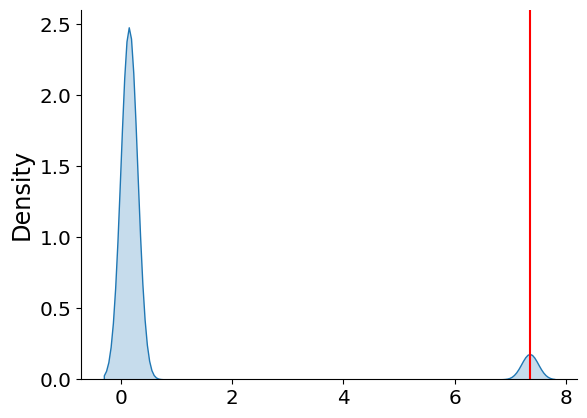

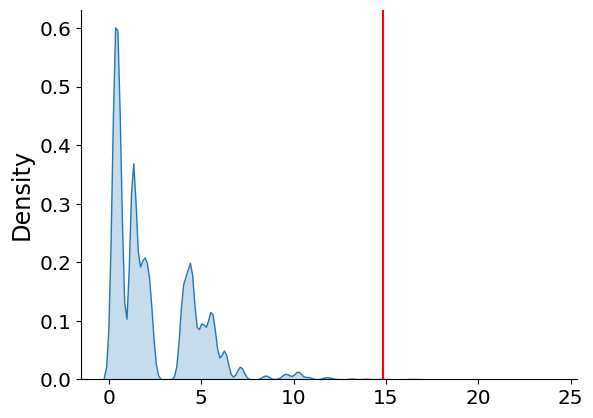

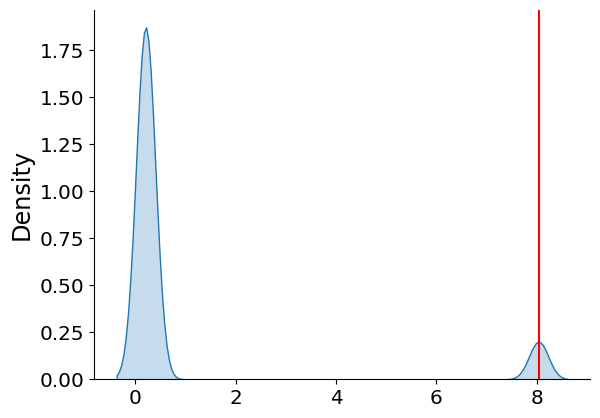

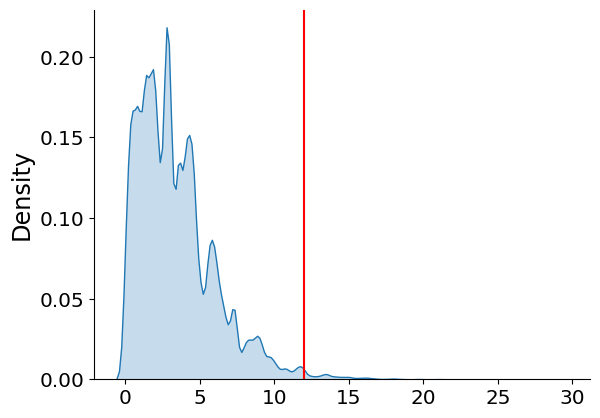

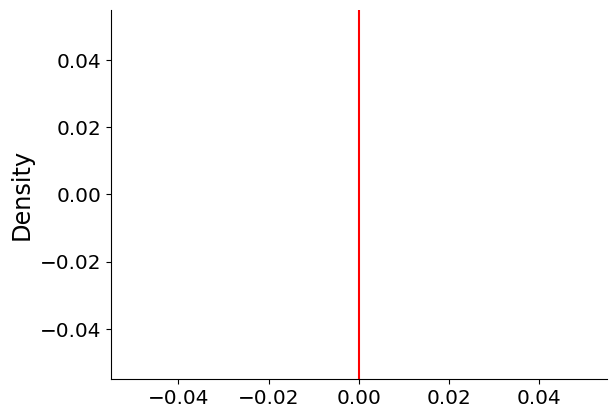

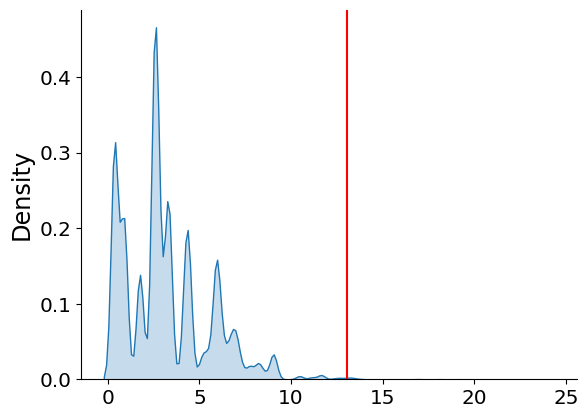

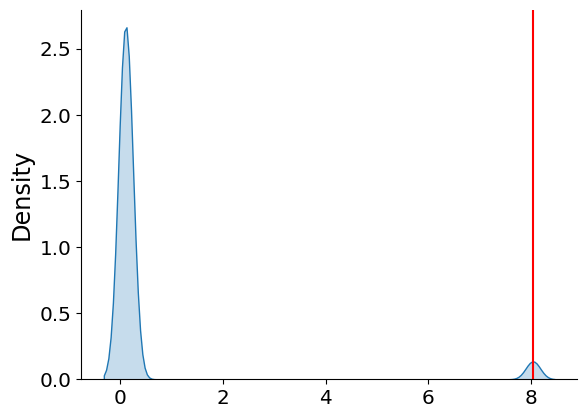

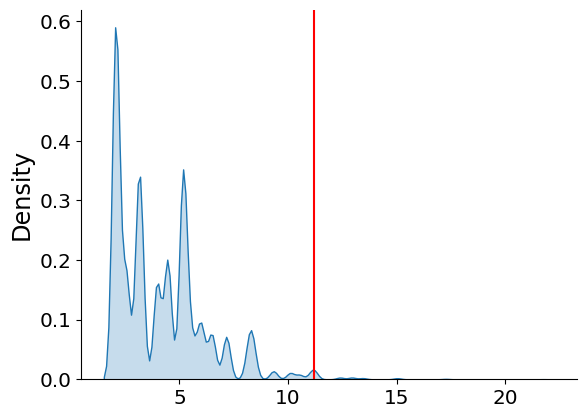

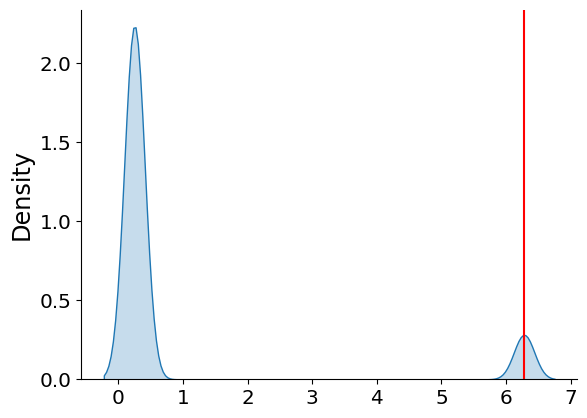

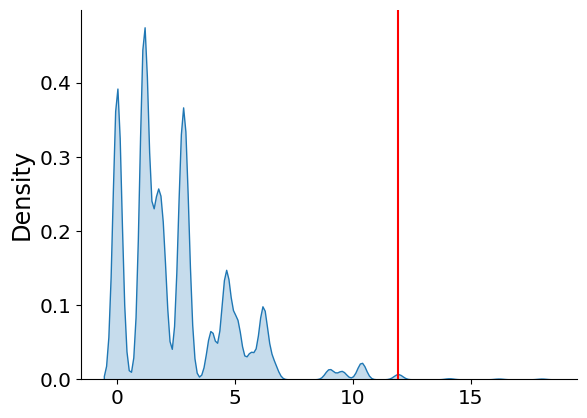

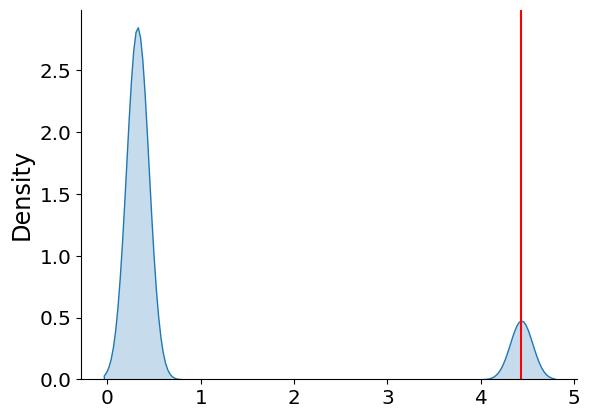

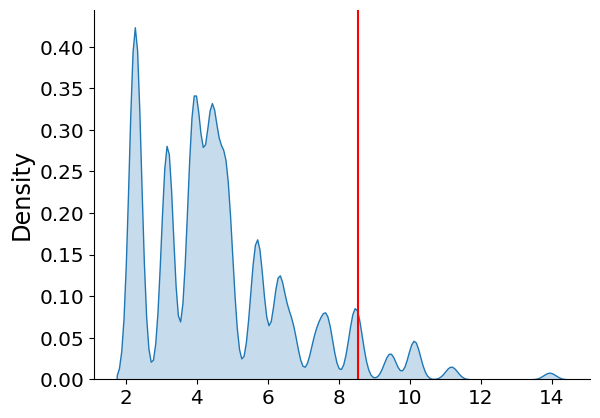

In [9]:
pvals_dct = {oc:{cn:{} for cn in conds} for oc in or_cells}
for oc in or_cells:
    for cn in conds:
        for tt in times:
            df_temp = df[(df.Culture_time==tt)&(df.Culture_condition==cn)&(df.Original_cell==oc)]
            nonatomic_families = [fam for fam in np.unique(df_temp.Family) if (df_temp.Family==fam).sum()>1]
            df_temp = df_temp[df_temp.Family.isin(nonatomic_families)]
            
            data = np.array([
                max(df_temp[(df_temp.Family==fam)].Generation.values)
                for fam in np.unique(df_temp.Family)], dtype=object)
        
            perm_label = np.array([
                df_temp[(df_temp.Family==fam)].Generation.values.max() - df_temp[(df_temp.Family==fam)].Generation.values.min()
                for fam in np.unique(df_temp.Family)])
            perm_label = (perm_label>0).astype(int)
            print(np.unique(perm_label, return_counts=True))
            
            table_support = np.unique(np.hstack(data))
            all_perm_labels = np.unique(perm_label)
            bool_stack = False
            args = (table_support, all_perm_labels, bool_stack,)
            
            pvals_dct[oc][cn][tt], stat, perm_stat = permutation_testing(chi_squared_stat, args, data, perm_label, boold_p_dist=True)
            print(oc, cn, tt)
        
            fig,ax = plt.subplots()
            sns.kdeplot(perm_stat, fill=True, ax=ax)
            ax.axvline(x=stat, c='r')
            sns.despine(fig=fig)
            fig.show()
    
    
print(pvals_dct)
with open('./pickled_data/maxdddist_nonatom_inexp_pvals.pkl', 'wb') as fp:
    pickle.dump(pvals_dct, fp)

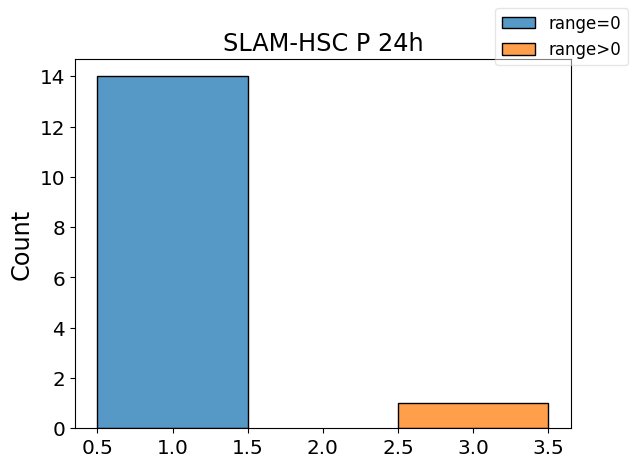

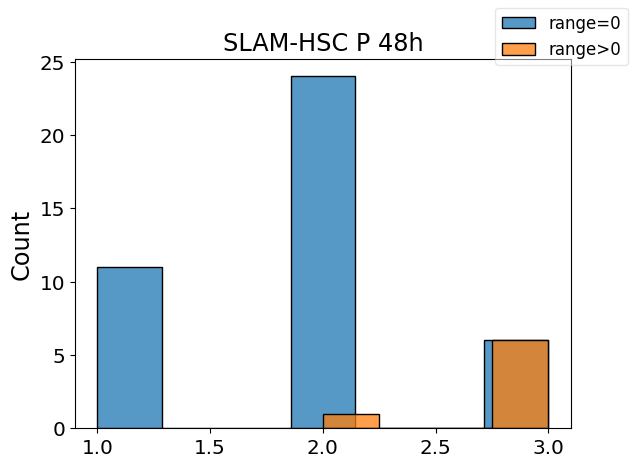

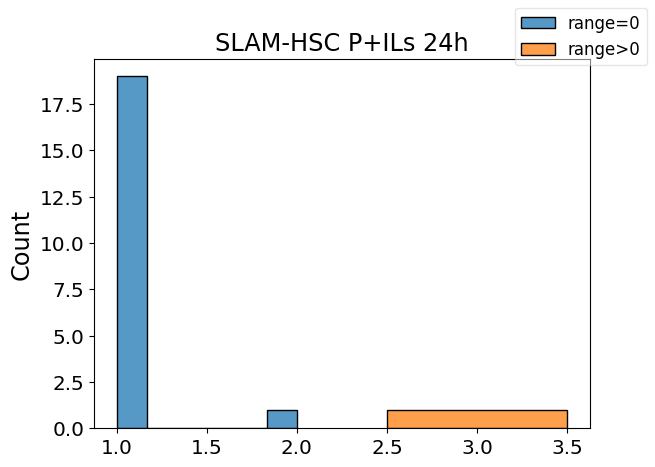

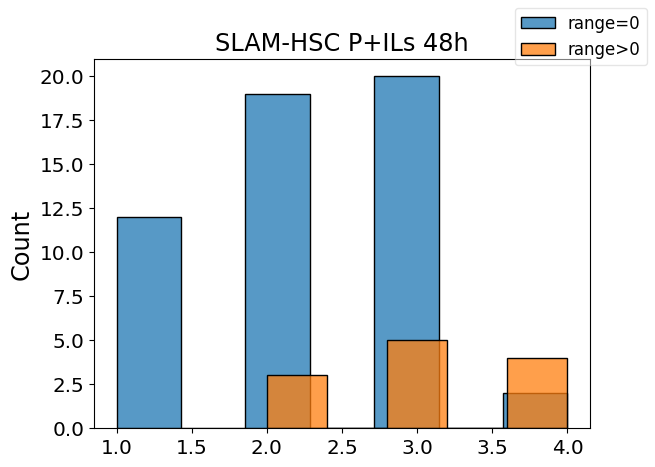

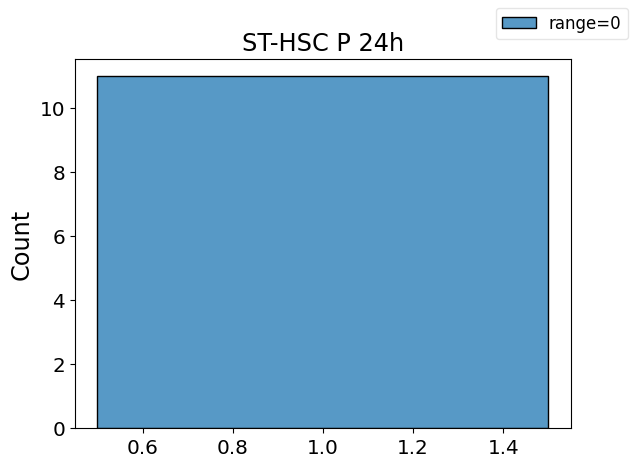

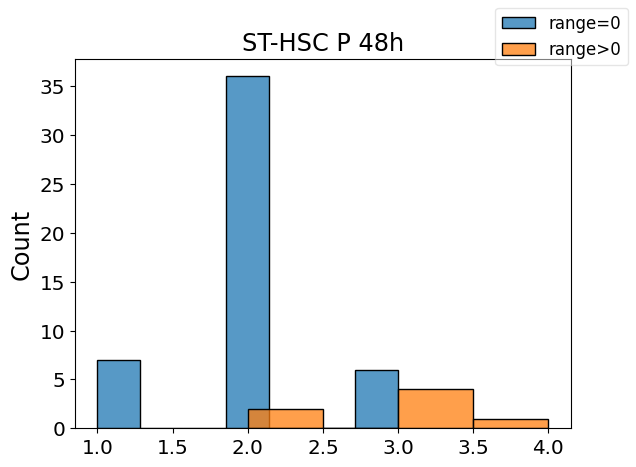

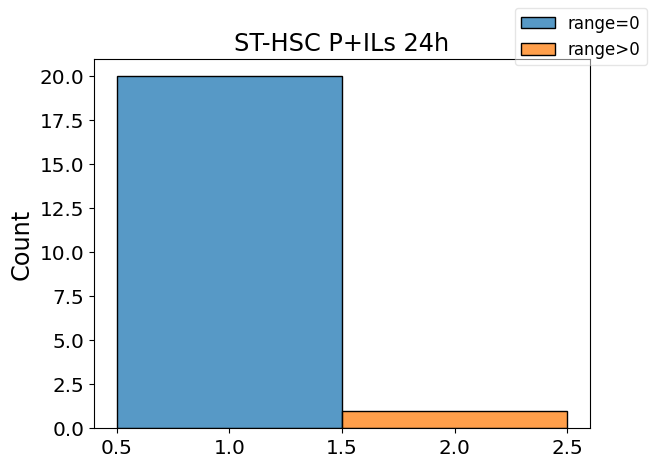

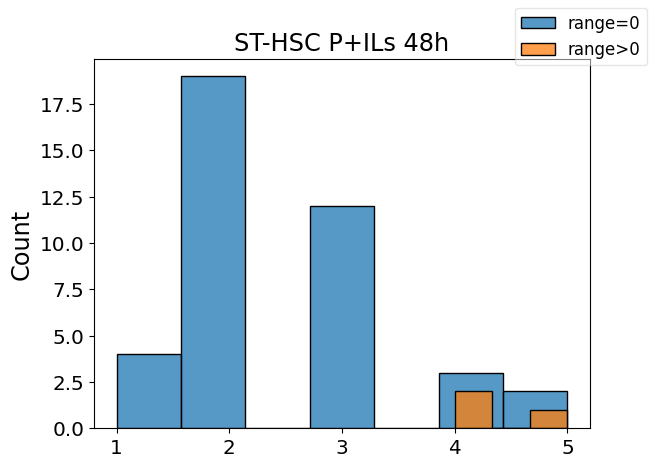

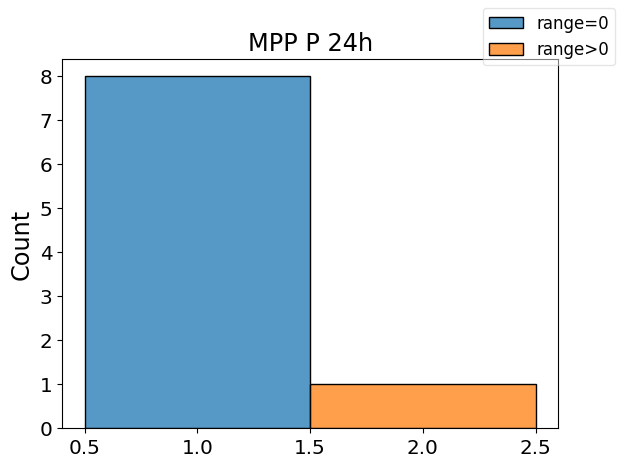

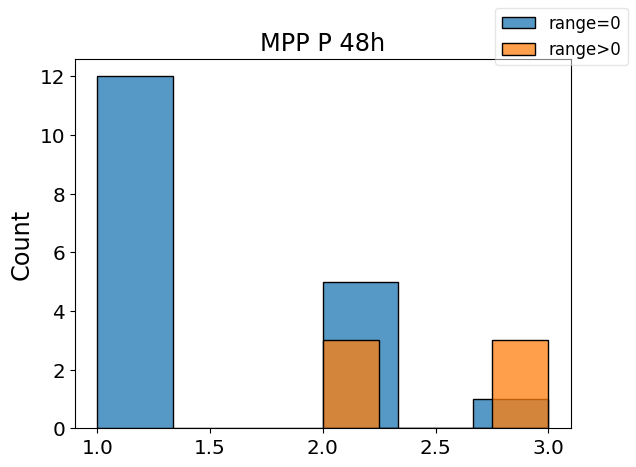

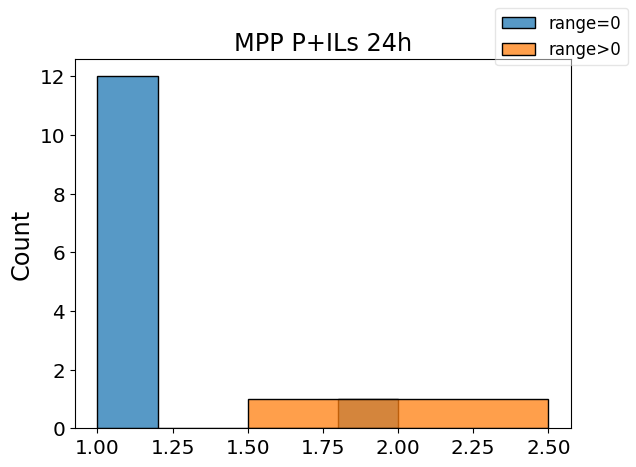

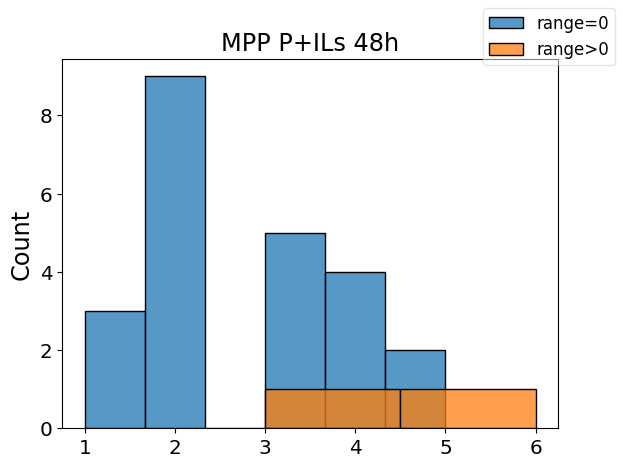

In [10]:
for oc in or_cells:
    for cn in conds:
        for tt in times[:]:
            df_temp = df[(df.Culture_time==tt)&(df.Culture_condition==cn)&(df.Original_cell==oc)]
            nonatomic_families = [fam for fam in np.unique(df_temp.Family) if (df_temp.Family==fam).sum()>1]
            df_temp = df_temp[df_temp.Family.isin(nonatomic_families)]

            data = np.array([
                max(df_temp[(df_temp.Family==fam)].Generation.values)
                for fam in np.unique(df_temp.Family)], dtype=object)
        
            perm_label = np.array([
                df_temp[(df_temp.Family==fam)].Generation.values.max() - df_temp[(df_temp.Family==fam)].Generation.values.min()
                for fam in np.unique(df_temp.Family)])
            perm_label = (perm_label>0).astype(int)
            fig,ax = plt.subplots()
            sns.histplot(data[perm_label==0], ax=ax, stat='count', label='range=0')
            sns.histplot(data[perm_label==1], ax=ax, stat='count', label='range>0')
            ax.set_title(' '.join([oc,cn,tt]))
            fig.legend()

## For each experiment (fixed original cell, fixed time and fixed condition), test whether range positivity (i.e. families with range>0 vs range=0) impacts the distribution of of distinct cell types within progeny

(array([0, 1]), array([14,  1]))
SLAM-HSC P 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/1745884110.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([41,  7]))
SLAM-HSC P 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/1745884110.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([20,  1]))
SLAM-HSC P+ILs 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/1745884110.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([53, 12]))
SLAM-HSC P+ILs 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/1745884110.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0]), array([11]))
ST-HSC P 24h
(array([0, 1]), array([49,  7]))


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/1745884110.py:28: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(perm_stat, fill=True, ax=ax)
/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/1745884110.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


ST-HSC P 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/1745884110.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([20,  1]))
ST-HSC P+ILs 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/1745884110.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([40,  3]))
ST-HSC P+ILs 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/1745884110.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([8, 1]))
MPP P 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/1745884110.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([18,  6]))
MPP P 48h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/1745884110.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([13,  1]))
MPP P+ILs 24h


/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/1745884110.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([0, 1]), array([23,  2]))
MPP P+ILs 48h
{'SLAM-HSC': {'P': {'24h': {'left': 1.0, 'right': 0.3983584065663737, 'two-sided': 0.7967168131327474}, '48h': {'left': 0.9318402726389095, 'right': 0.101187595249619, 'two-sided': 0.202375190499238}}, 'P+ILs': {'24h': {'left': 1.0, 'right': 0.382562469750121, 'two-sided': 0.765124939500242}, '48h': {'left': 0.9845720617117532, 'right': 0.024379902480390077, 'two-sided': 0.048759804960780154}}}, 'ST-HSC': {'P': {'24h': {'left': 1.0, 'right': 1.0, 'two-sided': 1}, '48h': {'left': 0.7739329042683829, 'right': 0.416438334246663, 'two-sided': 0.832876668493326}}, 'P+ILs': {'24h': {'left': 1.0, 'right': 0.47745409018363927, 'two-sided': 0.9549081803672785}, '48h': {'left': 0.998504005983976, 'right': 0.020307918768324926, 'two-sided': 0.04061583753664985}}}, 'MPP': {'P': {'24h': {'left': 0.5549737801048796, 'right': 1.0, 'two-sided': 1}, '48h': {'left': 0.9993960024159904, 'right': 0.014327942688229248, 'two-sided': 0.028655885376458495}}, 'P+I

/var/folders/89/tybg1jjn2nb2m704xf0j8w6h0000gn/T/ipykernel_74234/1745884110.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


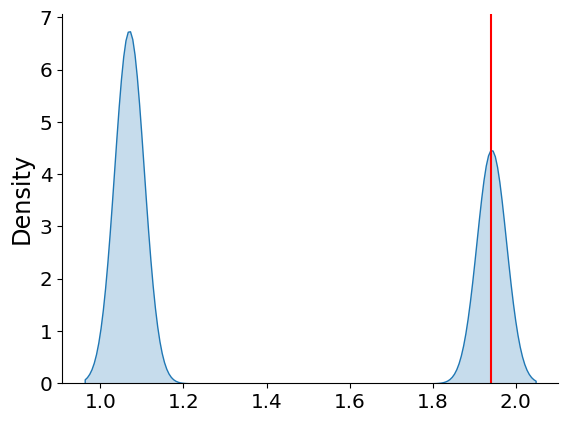

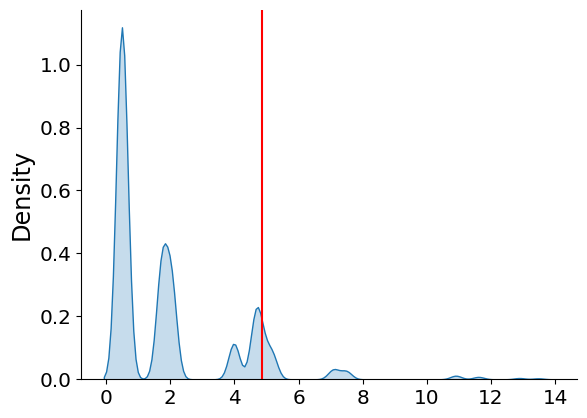

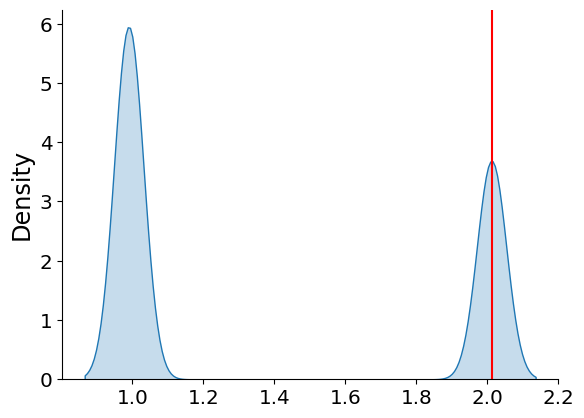

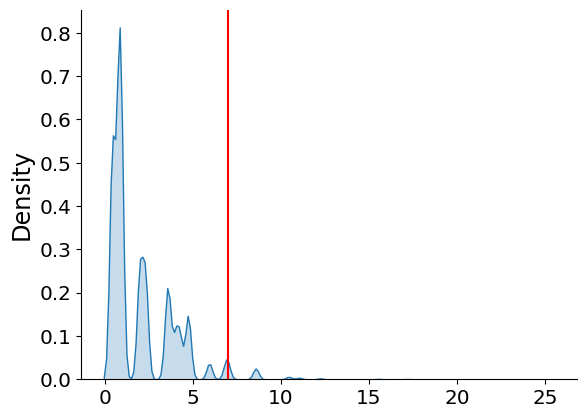

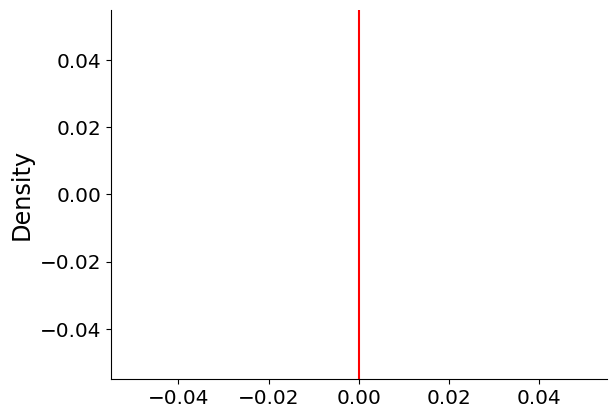

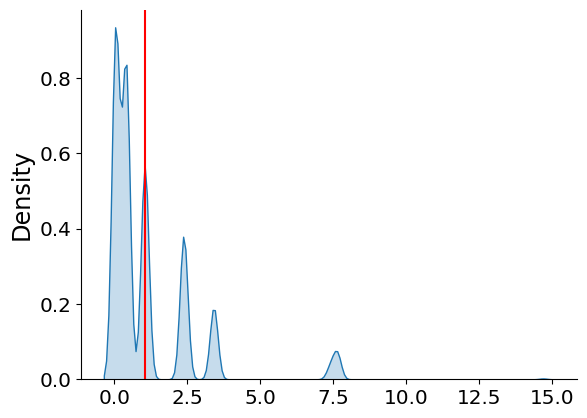

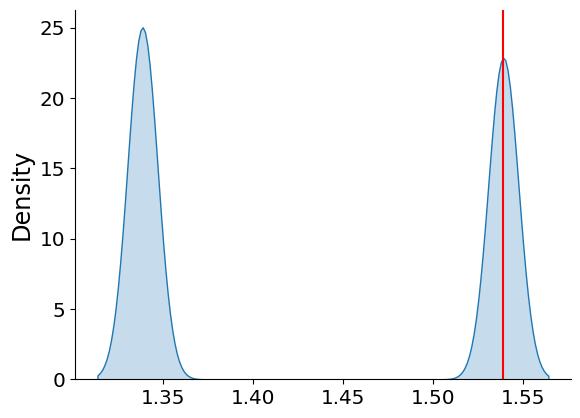

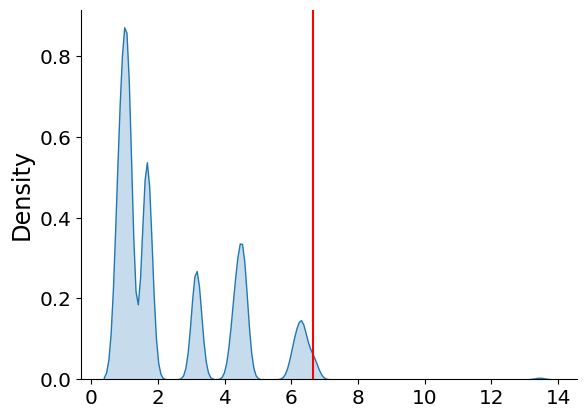

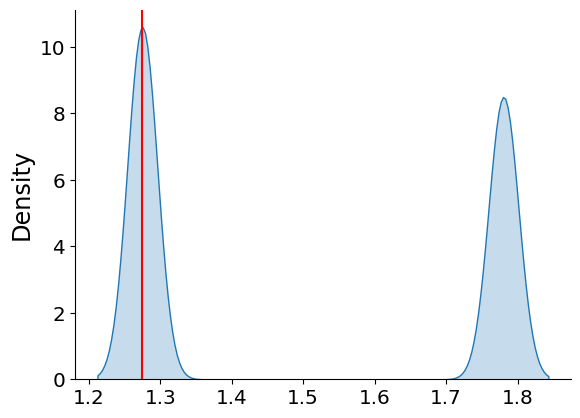

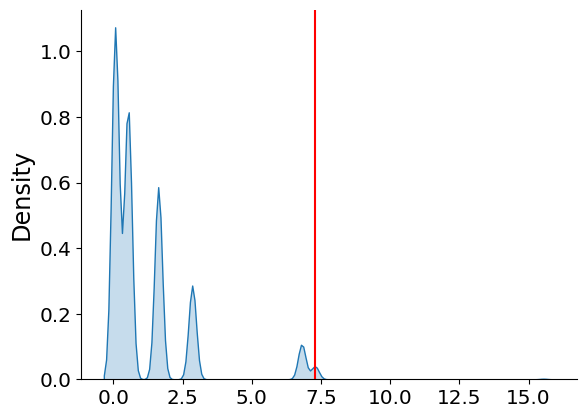

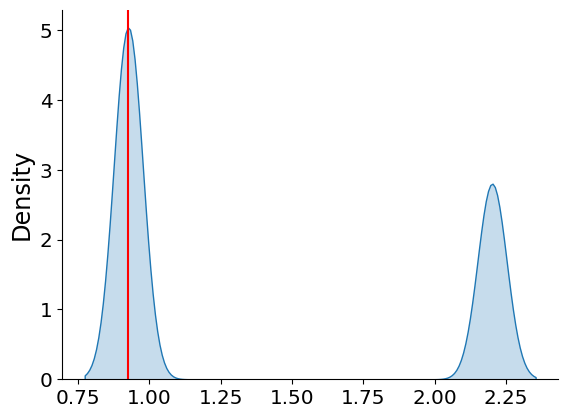

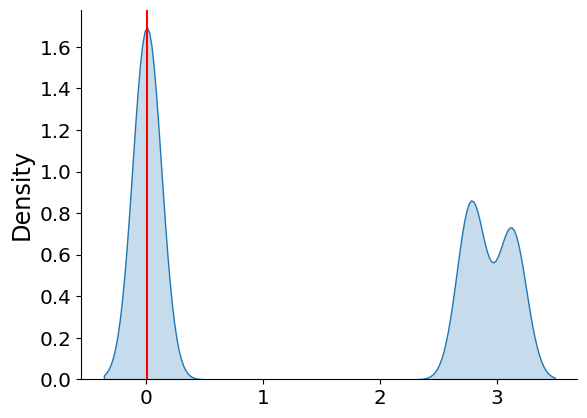

In [11]:
pvals_dct = {oc:{cn:{} for cn in conds} for oc in or_cells}
for oc in or_cells:
    for cn in conds:
        for tt in times:
            df_temp = df[(df.Culture_time==tt)&(df.Culture_condition==cn)&(df.Original_cell==oc)]
            nonatomic_families = [fam for fam in np.unique(df_temp.Family) if (df_temp.Family==fam).sum()>1]
            df_temp = df_temp[df_temp.Family.isin(nonatomic_families)]
            
            data = np.array([
                len(np.unique(df_temp[(df_temp.Family==fam)].Class.values))
                for fam in np.unique(df_temp.Family)])
        
            perm_label = np.array([
                df_temp[(df_temp.Family==fam)].Generation.values.max() - df_temp[(df_temp.Family==fam)].Generation.values.min()
                for fam in np.unique(df_temp.Family)])
            perm_label = (perm_label>0).astype(int)
            print(np.unique(perm_label, return_counts=True))
            
            table_support = np.unique(np.hstack(data))
            all_perm_labels = np.unique(perm_label)
            bool_stack = False
            args = (table_support, all_perm_labels, bool_stack,)
            
            pvals_dct[oc][cn][tt], stat, perm_stat = permutation_testing(chi_squared_stat, args, data, perm_label, boold_p_dist=True)
            print(oc, cn, tt)
        
            fig,ax = plt.subplots()
            sns.kdeplot(perm_stat, fill=True, ax=ax)
            ax.axvline(x=stat, c='r')
            sns.despine(fig=fig)
            fig.show()
    
    
print(pvals_dct)
with open('./pickled_data/lenunitype_nonatom_inexp_pvals.pkl', 'wb') as fp:
    pickle.dump(pvals_dct, fp)

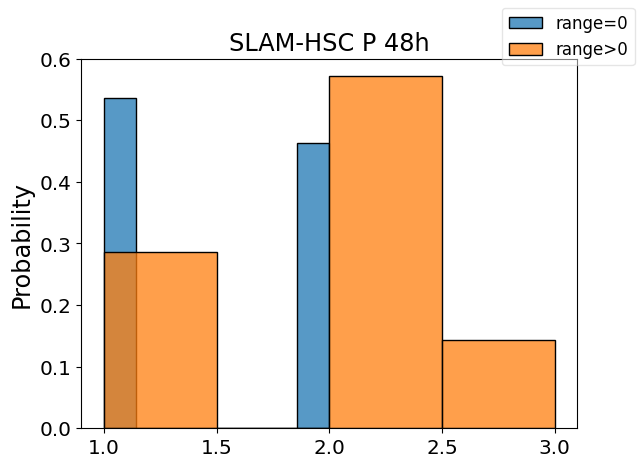

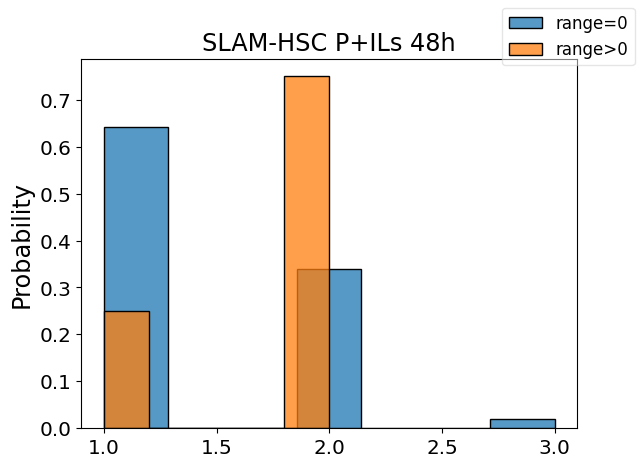

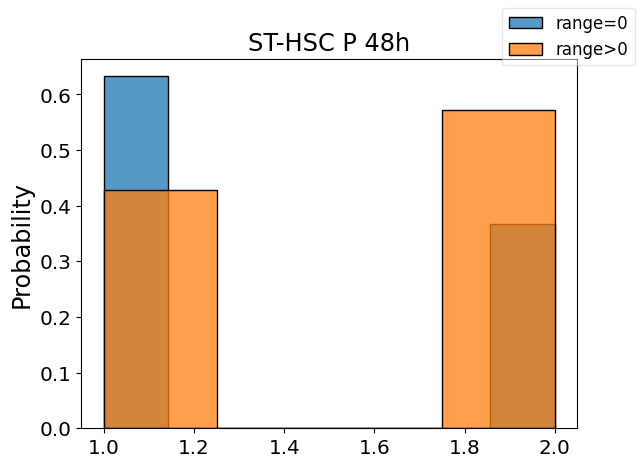

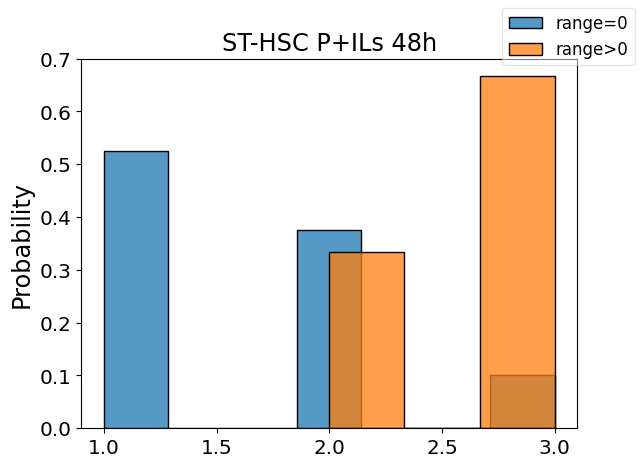

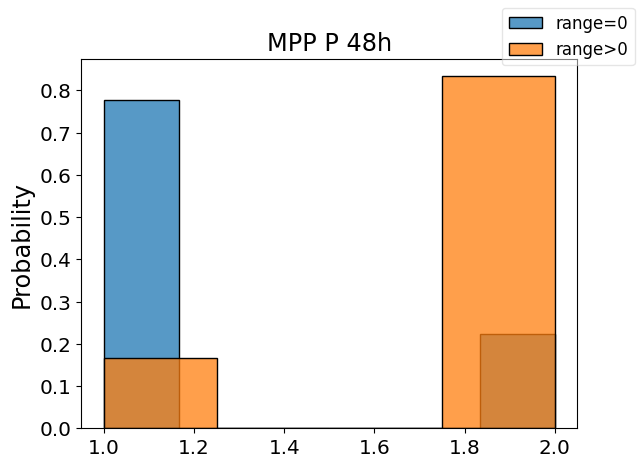

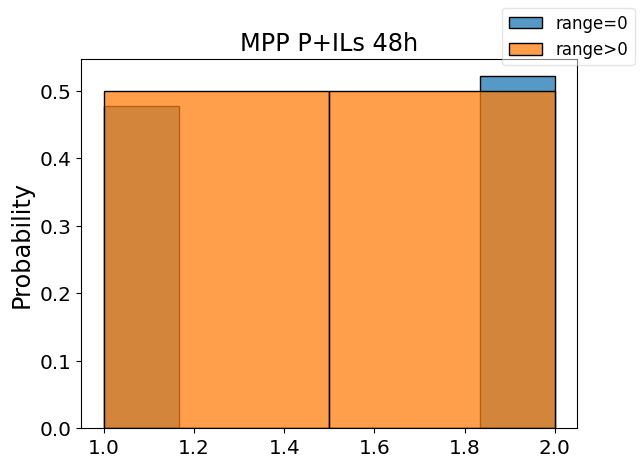

In [12]:
for oc in or_cells:
    for cn in conds:
        for tt in times[1:]:
            df_temp = df[(df.Culture_time==tt)&(df.Culture_condition==cn)&(df.Original_cell==oc)]
            nonatomic_families = [fam for fam in np.unique(df_temp.Family) if (df_temp.Family==fam).sum()>1]
            df_temp = df_temp[df_temp.Family.isin(nonatomic_families)]

            data = np.array([
                len(np.unique(df_temp[(df_temp.Family==fam)].Class.values))
                for fam in np.unique(df_temp.Family)])
        
            perm_label = np.array([
                df_temp[(df_temp.Family==fam)].Generation.values.max() - df_temp[(df_temp.Family==fam)].Generation.values.min()
                for fam in np.unique(df_temp.Family)])
            perm_label = (perm_label>0).astype(int)
            fig,ax = plt.subplots()
            sns.histplot(data[perm_label==0], ax=ax, stat='probability', label='range=0')
            sns.histplot(data[perm_label==1], ax=ax, stat='probability', label='range>0')
            ax.set_title(' '.join([oc,cn,tt]))
            fig.legend()

## Concisely print the p-values

In [14]:
print('lenunique_cvc_pvals')
with open('./pickled_data/lenunique_cvc_pvals.pkl', 'rb') as fp:
    pvals_dct = pickle.load(fp)

for k in pvals_dct:
    for i in pvals_dct[k]:
        #for j in pvals_dct[k][i]:
        print(k, i, pvals_dct[k][i]['right'])


print('classdist_cvc_pvals')
with open('./pickled_data/classdist_cvc_pvals.pkl', 'rb') as fp:
    pvals_dct = pickle.load(fp)

for k in pvals_dct:
    for i in pvals_dct[k]:
        #for j in pvals_dct[k][i]:
        print(k, i, pvals_dct[k][i]['right'])


print('rangedist_tvt_pvals')
with open('./pickled_data/rangedist_tvt_pvals.pkl', 'rb') as fp:
    pvals_dct = pickle.load(fp)

for k in pvals_dct:
    for i in pvals_dct[k]:
        #for j in pvals_dct[k][i]:
        print(k, i, pvals_dct[k][i]['right'])


print('classtypedist_nonatom_inexp_pvals')
with open('./pickled_data/classtypedist_nonatom_inexp_pvals.pkl', 'rb') as fp:
    pvals_dct = pickle.load(fp)

for k in pvals_dct:
    for i in pvals_dct[k]:
        for j in pvals_dct[k][i]:
            print(k, i, j, pvals_dct[k][i][j]['right'])


print('maxdddist_nonatom_inexp_pvals')
with open('./pickled_data/maxdddist_nonatom_inexp_pvals.pkl', 'rb') as fp:
    pvals_dct = pickle.load(fp)

for k in pvals_dct:
    for i in pvals_dct[k]:
        for j in pvals_dct[k][i]:
            print(k, i, j, pvals_dct[k][i][j]['right'])


print('lenunitype_nonatom_inexp_pvals')
with open('./pickled_data/lenunitype_nonatom_inexp_pvals.pkl', 'rb') as fp:
    pvals_dct = pickle.load(fp)

for k in pvals_dct:
    for i in pvals_dct[k]:
        for j in pvals_dct[k][i]:
            print(k, i, j, pvals_dct[k][i][j]['right'])

lenunique_cvc_pvals
SLAM-HSC 24h 0.7847688609245563
SLAM-HSC 48h 0.9313882744469022
ST-HSC 24h 0.0014879940480238079
ST-HSC 48h 0.013095947616209535
MPP 24h 0.7544889820440718
MPP 48h 0.22995908016367936
classdist_cvc_pvals
SLAM-HSC 24h 0.5055259778960884
SLAM-HSC 48h 0.12663549345802616
ST-HSC 24h 0.04738781044875821
ST-HSC 48h 7.999968000127999e-06
MPP 24h 0.00045999816000736
MPP 48h 3.9999840000639995e-06
rangedist_tvt_pvals
SLAM-HSC P 0.00213999144003424
SLAM-HSC P+ILs 2.7999888000448e-05
ST-HSC P 0.002635989456042176
ST-HSC P+ILs 0.296938812244751
MPP P 0.040759836960652156
MPP P+ILs 0.7005371978512086
classtypedist_nonatom_inexp_pvals
SLAM-HSC P 24h 0.4680341278634885
SLAM-HSC P 48h 0.2091071635713457
SLAM-HSC P+ILs 24h 0.19119123523505907
SLAM-HSC P+ILs 48h 0.1838552645789417
ST-HSC P 24h 1.0
ST-HSC P 48h 0.19035523857904568
ST-HSC P+ILs 24h 0.9525361898552406
ST-HSC P+ILs 48h 0.651309394762421
MPP P 24h 0.44462222151111397
MPP P 48h 0.09910760356958573
MPP P+ILs 24h 0.284934860